# Griddap

Erddapy can access gridded datasets,
using the server-side subsetting of griddap or the OPeNDAP response,
to download only the parts of a dataset that the user requires.

In our example we will use a Region of Interest (ROI) to extract data within its bounds.
First we need to read the ROI with `geopandas`.
Let's use the South Atlantic Ocean basin from Natural Earth as our ROI.

In [1]:
import geopandas
import pooch

url = "https://naturalearth.s3.amazonaws.com/4.1.1/50m_physical/ne_50m_geography_marine_polys.zip"
fname = pooch.retrieve(
    url,
    known_hash="db6f59e5a747c016451caec2450db6deea25d702dc2fb9c39384c1b909fb7f72",
)

oceans = geopandas.read_file(fname)

name = "South Atlantic Ocean"
SA = oceans.loc[oceans["name"] == name]

When accessing gridded datasets we need to define the `protocol="griddap"` in
our class instantiation.


In [2]:
from erddapy import ERDDAP

e = ERDDAP(
    server="https://pae-paha.pacioos.hawaii.edu/erddap",
    protocol="griddap",
)

e.dataset_id = "etopo5_lon180"

CAVEAT: Note that ERDDAP can serve gridded data with longitudes in the 0&ndash;360 format or -180&ndash;180.
The user must inspect the dataset and modify your query accordingly.

Information on the griddap dataset is fetched with `griddap_initialize`.
This fills in the `variables` and `constraints` properties for that dataset.

In [3]:
import json

e.griddap_initialize()

print(f"variables in this dataset:\n\n{e.variables}")
constraints = json.dumps(e.constraints, indent=1)
print(f"\nconstraints of this dataset:\n\n{constraints}")

variables in this dataset:

['ROSE']

constraints of this dataset:

{
 "latitude>=": -90.0,
 "latitude<=": 90.0,
 "latitude_step": 1,
 "longitude>=": -179.99833294744155,
 "longitude<=": 179.91833294744154,
 "longitude_step": 1
}


The default behaviour is to use erddap standard subsetting to return all variables at the most recent timestep and every point of the remaining dimensions.

This can result in large data requests!
However, the values of the constraints can be changed and variables dropped before data set is downloaded.
Here we will download only one variable from that list.

In [4]:
e.variables = [e.variables[0]]

print(f"Downloading {e.variables}.")

And we will reduce the dataset a bit further by requesting only the data that is inside the bounding box of the South Atlantic.

In [5]:
SA.bounds

,minx,miny,maxx,maxy
6,-69.092082,-60.533462,19.634854,0.032867


In [6]:
def bounds2contraints(bounds):
    return {
        "longitude>=": bounds.minx.squeeze(),
        "longitude<=": bounds.maxx.squeeze(),
        "latitude>=": bounds.miny.squeeze(),
        "latitude<=": bounds.maxy.squeeze(),
    }


e.constraints.update(bounds2contraints(SA.bounds))
e.constraints

{'latitude>=': -60.53346241642455,
 'latitude<=': 0.03286652261984102,
 'latitude_step': 1,
 'longitude>=': -69.09208207871731,
 'longitude<=': 19.63485354989288,
 'longitude_step': 1}

Note the new longitude/latitude limits in the query above.
New can download the data into an `xarray.Dataset` object.

In [7]:
%%time


ds = e.to_xarray()

CPU times: user 113 ms, sys: 18.9 ms, total: 131 ms
Wall time: 2.32 s


Once downloaded data can be quickly visualised with xarray's inbuilt plotting
functionality.

/home/runner/micromamba/envs/TEST/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


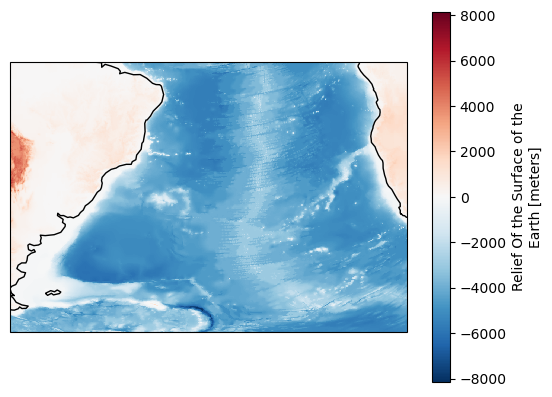

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ds["ROSE"].plot(ax=ax)
ax.coastlines();

Note that we did not extract the exact ROI but instead we downloaded what is inside a square defined by its bounds.
We can refine the data selection using region mask and download strictly what is inside th ROI.

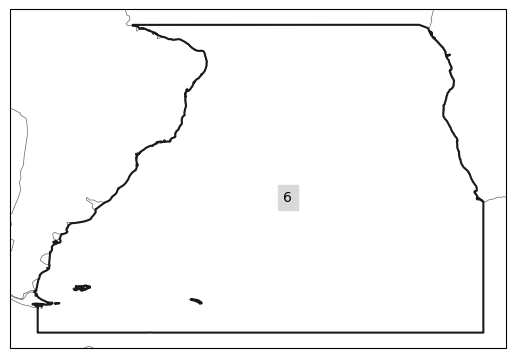

In [9]:
import regionmask

region = regionmask.from_geopandas(SA, name=name)
region.plot();

/home/runner/micromamba/envs/TEST/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/tmp/ipykernel_3502/764052456.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


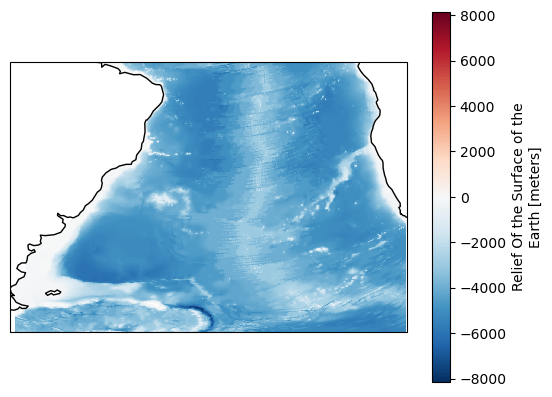

In [10]:
mask = region.mask(
    ds,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ds["ROSE"].where(mask == region.numbers[0]).plot(ax=ax)
ax.coastlines();

Now we have data only for the Altantic Ocean, no land data in our plot.

### Subset after the request with OPeNDAP

ERDDAP server-side subsetting can be avoided by specifying the OPeNDAP protocol.
This is a good choice if you intend to use a full dataset or subset it after the request.

Note that most OPeNDAP clients will eagerly download only the coordinates,
making a post request subset almost as fast as serve-side subset.

In [11]:
e = ERDDAP(
    server="https://pae-paha.pacioos.hawaii.edu/erddap",
    protocol="griddap",
    response="opendap",
)

e.dataset_id = "etopo5_lon180"

The data can be downloaded immediately, no need to run `griddap_initialize`


In [12]:
%%time

ds = e.to_xarray()

CPU times: user 14.5 ms, sys: 633 μs, total: 15.1 ms
Wall time: 1.4 s


Let's take a quick look at the data.


CPU times: user 6.89 s, sys: 432 ms, total: 7.32 s
Wall time: 41.2 s


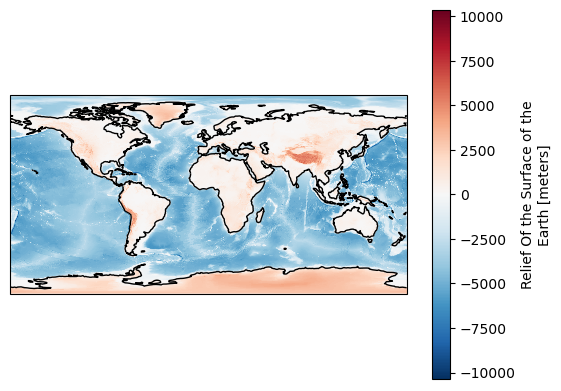

In [13]:
%%time

projection = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw={"projection": projection})
ds["ROSE"].plot(ax=ax)
ax.coastlines();

/home/runner/micromamba/envs/TEST/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/tmp/ipykernel_3502/764052456.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


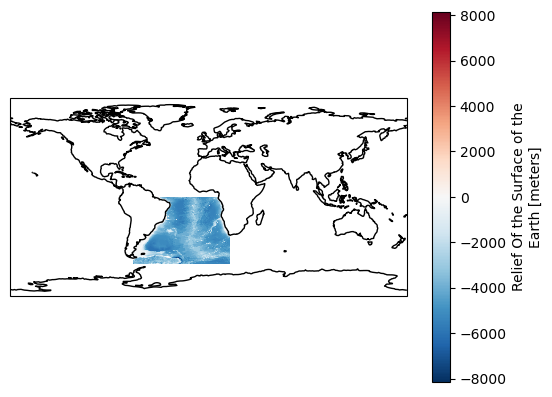

In [14]:
mask = region.mask(
    ds,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ds["ROSE"].where(mask == region.numbers[0]).plot(ax=ax)
ax.coastlines();